# Making a Sequence Coverage Plot from an Alignment File

## Calculating coverage from queries

Each query (read) maps to a region of the sequence (sstart - send), with the read start mapping to sstart and read end mapping to send. With a paired-end reads, sstart can be greater than send. 

For the purposes of making this sequence coverage viewer, I will use the small [lambda phage genome](https://www.ncbi.nlm.nih.gov/nuccore/NC_001416.1?report=fasta) and generate 150bp single end reads. 

In [1]:
#load some standard libraries

import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import plotly.express as px

In [2]:
#load in phage genome fasta
fasta_file = open("Lambda_phage_genome.fa")
ref_seq = fasta_file.read().split('\n', 1)[1] #remove the header
ref_seq = ref_seq.rstrip('\n') #remove trailing newline
ref_seq = ref_seq.replace('\n','') #remove middle newlines
ref_seq_list = list(ref_seq)
len(ref_seq_list)

48502

In [3]:
#generate 5000 150bp reads - sequence positions are 1-based as in SAM/BAM files
rnd.seed(42)
start_pos_all = np.array(rnd.choices(range(1,len(ref_seq_list)-150), k = 5000)) #sample with replacement
end_pos_all = start_pos_all + 150 #add 150bp to sstart to get where end of the read maps

In [4]:
print(f'total reads: {len(start_pos_all)}')
print(f'covered sequence: {np.min(start_pos_all)} - {np.max(end_pos_all)}bp')

total reads: 5000
covered sequence: 5 - 48497bp


A simple way to do the coverage plot is to build a new dataframe that contains:

1. sequence position (bp)
2. number of reads overlapping the position (int)

This can be done by iterating through the sequence and counting up the number of overlapping reads via subsetting.

In [6]:
%%timeit
'''
Get coverage over a region of a sequence (bp-resolution) using list comprehension
1. calculate total of all queries with start position less than x (bp)
2. calculate total of all queries with end position less than x (bp)
3. difference between (1) and (2) is the number of queries overlapping x (bp)
4. loop over the sequence region of interest
'''
start_pos = start_pos_all.tolist()
end_pos = end_pos_all.tolist()

coverage_1 = [sum(1 for i in start_pos if i <= x) - sum(1 for i in end_pos if i <= x) for x in range(1,10000)]

3.13 s ± 307 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Algorithms that involve searches end up being slow on large regions of interest. A more efficient algorithm will calculate coverage without doing searches through all the queries for each sequence position. 

In [7]:
%%timeit
'''
Get coverage over a region of the sequence by jumping between 
start and end positions of reads, incrementing coverage as you go. 
Infers that until you encounter the start or end of a read, you
do not change the coverage value, and therefore you avoid looping 
over all bp of interest, saving time. 
'''
#start and end values must be sorted low to high
start_pos = start_pos_all.copy()
start_pos.sort()
end_pos = end_pos_all.copy()
end_pos.sort()
#define region of interest
start_region = 1
end_region = 10000
#moving pointer for sequence position
seq_pos = start_region
#running coverage value
cov = 0
#initialize empty array to store coverage values
coverage = np.zeros(end_region-(start_region-1))
#moving pointer for index in coverage array
idx = 0
#initialize indices at 0
i=0
j=0

#while within the index range of the reads
while (j < len(start_pos) and i < len(end_pos)): 
    #if you haven't hit the start of the last read and encounter the start position of a read first
    if (j < (len(start_pos) - 1) and start_pos[j] < end_pos[i]):
        seq_pos_jump = start_pos[j] #jump to start_pos[j]
        j += 1 #increment index
        cov_increment = 1 #increment coverage value
    #if you encounter the end position of a read first or you've reached the start of the last read
    elif (start_pos[j] > end_pos[i] or j == len(start_pos)-1):
        seq_pos_jump = end_pos[i] #jump to end_pos[i]
        i += 1 #increment index
        cov_increment = -1 #decrement coverage value    
    #if you encounter start and end position of a read at the same position   
    else:
        seq_pos_jump = start_pos[j]+1 #jump by 1bp
        cov_increment = 1 #increment coverage value
        j+=1
    
    #store the constant coverage value from seq_pos to seq_pos_jump, correcting for 0-indexing
    jump = idx + (seq_pos_jump - seq_pos)  
    if jump <= len(coverage):
        coverage[idx:jump] = [cov] * (seq_pos_jump - seq_pos)
    else:
        coverage[idx:] = [cov] * (len(coverage) - idx) #if you run out of room in the array
        break

    idx = jump #update index
    cov += cov_increment #update coverage value
    seq_pos = seq_pos_jump #update seq position

5.38 ms ± 631 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
%%timeit
'''
Get coverage over a region of the sequence by iterating through
the reads and incrementing coverage in the region of the genome
that the read covers. 
'''
#define region of interest
start_region = 1
end_region = 10000

#initialize empty array to store coverage values
genome_coverage = np.zeros(end_region-(start_region-1))

#pick reads that fall within the region of interest
#ignore all reads that end before region of interest and start after region of interest
start_pos = start_pos_all[~((end_pos_all < start_region) & (start_pos_all > end_region))]
end_pos = end_pos_all[~((end_pos_all < start_region) & (start_pos_all > end_region))]

#iterate through reads and increment coverage
for i in range(0, len(start_pos)):
    genome_coverage[start_pos[i]:end_pos[i]] += 1

7.3 ms ± 367 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The last two methods are the fastest to generate coverage values. Wrap them into functions for plotting. 

In [9]:

def get_sequence_coverage1(start_pos_all:np.array, end_pos_all:np.array, start_region:int, end_region:int):
    '''
    Get coverage over a region of the sequence by jumping between 
    start and end positions of reads, incrementing coverage as you go. 
    Infers that until you encounter the start or end of a read, you
    do not change the coverage value, and therefore you avoid looping 
    over all bp of interest, saving time.
    
    start_pos_all: array of all sequence start positions for reads 
    end_pos_all: array of all sequence end positions for reads. Must be greater than start_pos_all for a single read
    start_region: starting bp of region of interest for plotting (int). min value = 1
    end_region: end bp of region of interest for plotting (int). Greater than start_region
    
    Requires numpy (import as np)
    '''
    #start and end values must be sorted low to high
    start_pos = start_pos_all[~(end_pos_all < start_region)] #ignore all reads that end before region of interest
    end_pos = end_pos_all[~(end_pos_all < start_region)]

    start_pos.sort()
    end_pos.sort()
    
    start_pos[start_pos < start_region] = start_region #truncate reads that start before region of interest
    
    #moving pointer for sequence position
    seq_pos = start_region
    #running coverage value
    cov = 0
    #initialize empty array to store coverage values
    coverage = np.zeros(end_region-(start_region-1))
    #moving pointer for index in coverage array
    idx = 0
    #initialize indices at 0
    i=0
    j=0
    
    #while within the index range of the reads
    while (j < len(start_pos) and i < len(end_pos)): 
        #if you haven't hit the start of the last read and encounter the start position of a read first
        if (j < (len(start_pos) - 1) and start_pos[j] < end_pos[i]):
            seq_pos_jump = start_pos[j] #jump to start_pos[j]
            j += 1 #increment index
            cov_increment = 1 #increment coverage value
        #if you encounter the end position of a read first or you've reached the start of the last read
        elif (start_pos[j] > end_pos[i] or j == len(start_pos)-1):
            seq_pos_jump = end_pos[i] #jump to end_pos[i]
            i += 1 #increment index
            cov_increment = -1 #decrement coverage value    
        #if you encounter start and end position of a read at the same position   
        else:
            seq_pos_jump = start_pos[j]+1 #jump by 1bp
            cov_increment = 1 #increment coverage value
            j+=1
        #store the constant coverage value from seq_pos to seq_pos_jump, correcting for 0-indexing
        jump = idx + (seq_pos_jump - seq_pos)  
        if jump <= len(coverage):
            coverage[idx:jump] = [cov] * (seq_pos_jump - seq_pos)
        else:
            coverage[idx:] = [cov] * (len(coverage) - idx) #if you run out of room in the array
            break

        idx = jump #update index
        cov += cov_increment #update coverage value
        seq_pos = seq_pos_jump #update seq position
    
    return coverage


In [10]:
def get_sequence_coverage2(start_pos_all:np.array, end_pos_all:np.array, start_region:int, end_region:int):
    '''
    Get coverage over a region of the sequence by iterating through
    the reads and incrementing coverage in the region of the genome
    that the read covers. 

    start_pos_all: array of all sequence start positions for reads 
    end_pos_all: array of all sequence end positions for reads. Must be greater than start_pos_all for a single read
    start_region: starting bp of region of interest for plotting (int). min value = 1
    end_region: end bp of region of interest for plotting (int). Greater than start_region
    
    Requires numpy (import as np)
    '''
    #initialize empty array to store coverage values
    genome_coverage = np.zeros(end_region-(start_region-1))

    #pick reads that fall within the region of interest
    #ignore all reads that end before region of interest and start after region of interest
    start_pos = start_pos_all[~((end_pos_all < start_region) & (start_pos_all > end_region))]
    end_pos = end_pos_all[~((end_pos_all < start_region) & (start_pos_all > end_region))]

    #iterate through reads and increment coverage
    for i in range(0, len(start_pos)):
        genome_coverage[start_pos[i]:end_pos[i]] += 1
    
    return genome_coverage

In [11]:
def plot_coverage(start_pos_all:np.array, end_pos_all:np.array, start_region:int, end_region:int, version = 1):
    
    '''
    Plots output of get_sequence_coverage(). Requires matplotlib.pyplot (plt)
    version: 1 uses get_sequence_coverage1, 2 uses get_sequence_coverage2
    '''
    if version == 2:
        coverage = get_sequence_coverage2(start_pos_all, end_pos_all, start_region, end_region)
    else:
        coverage = get_sequence_coverage1(start_pos_all, end_pos_all, start_region, end_region)
        
    #plotting
    fig, ax = plt.subplots(1,1, figsize=(20,6))
    ax.bar(range(start_region, end_region+1), coverage, width=1, \
           color = 'silver', edgecolor = 'dimgray',linewidth = 1,align='center')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    ax.set_xlabel('Sequence Position', fontsize = 18)
    ax.set_ylabel('Coverage', fontsize = 18)
    ax.tick_params(labelsize = 16)
    plt.margins(0,0.05)


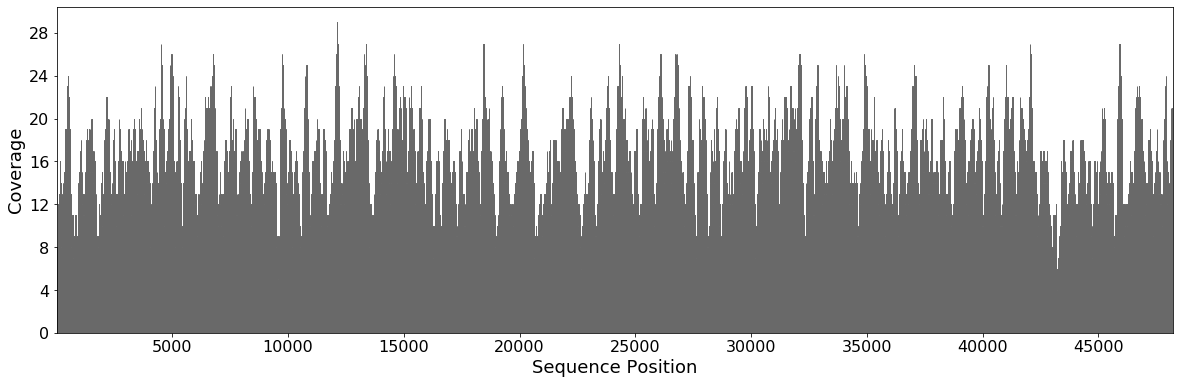

In [15]:
plot_coverage(start_pos_all, end_pos_all, 1, 48200)


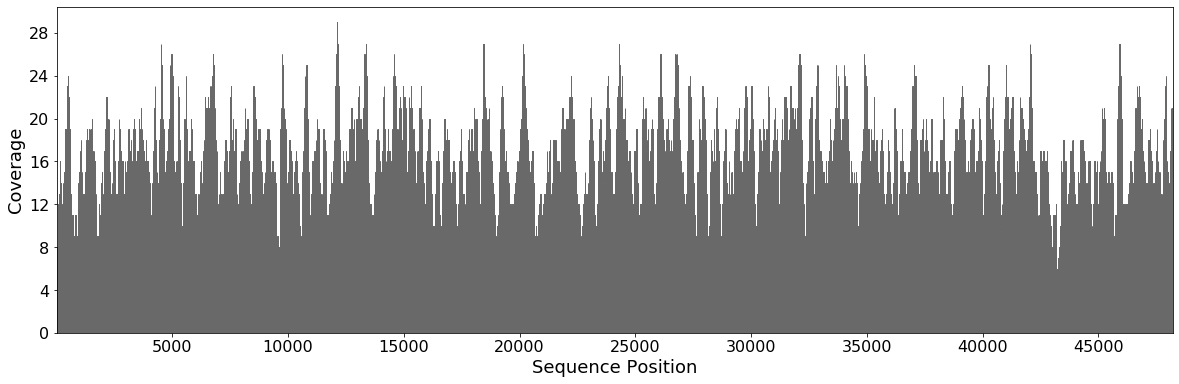

In [16]:
plot_coverage(start_pos_all, end_pos_all, 1, 48200, version = 2)

## Adding mutation information

Info on mutations should be transformed to a data frame with the sequence and counts of associated mutations

In [23]:
#generate mutations
rnd.seed(42)
mut_pos = np.array(rnd.choices(range(1,len(ref_seq_list)+1), k = 40000)) #sample with replacement
muts = np.array(rnd.choices(['A','T','C','G'], k = 40000)) #sample with replacement

muts_df = pd.DataFrame({'pos':mut_pos, 'mut':muts})
muts_df.head()

,pos,mut
0,31014,T
1,1214,G
2,13340,T
3,10827,T
4,35721,T


In [40]:
#filter out "mutations" that do not differ from reference seq

ref_seq_df = pd.DataFrame({'pos':range(1,len(ref_seq_list)+1), 'base':ref_seq_list})

comb_df = pd.merge(muts_df, ref_seq_df, how = 'left', on ='pos')
comb_df = comb_df[~(comb_df['mut'] == comb_df['base'])]
comb_df.head()

,pos,mut,base
0,31014,T,G
1,1214,G,T
2,13340,T,C
3,10827,T,C
5,32822,A,C


In [43]:
#make dummy columns for mutation, group by position, and sum to get counts of each mutation for each position
muts_df_summary = pd.get_dummies(comb_df, columns = ['mut']).groupby('pos').sum()

#check for counts of double mutations
muts_df_summary.loc[(muts_df_summary['mut_A'] > 0) & (muts_df_summary['mut_C'] > 0)].head()

,mut_A,mut_C,mut_G,mut_T
pos,,,,
32,1,1,0,0
147,1,1,0,0
156,1,1,0,0
168,1,1,1,0
182,1,1,0,0


In [51]:
def plot_coverage_muts(start_pos_all:np.array, end_pos_all:np.array, start_region:int, end_region:int,
                      muts_df_summary:pd.DataFrame, ref_seq_list:list, version = 1):
    '''
    Plots mutation information on top of coverage plot in interactive plot.
    Uses get_sequence_coverage() and joins it with muts_df_summary, 
    a dataframe with sequence position and counts of mutation types. 
    
    Each bar is colored by the fraction of reads that have a mutation.
    Hovertext shows counts of alternate bp and the reference seq bp
    At high zoom, shows ref seq bp on top of the bar. 
    
    Input:
        start_pos_all: array of all sequence start positions for reads 
        end_pos_all: array of all sequence end positions for reads. 
                     Must be greater than start_pos_all for a single read
        start_region: starting bp of region of interest for plotting (int). min value = 1
        end_region: end bp of region of interest for plotting (int). Greater than start_region
        muts_df_summary: pandas dataframe indexed by sequence position with 4 columns: 
                         mut_A, mut_C, mut_G, mut_T i.e.
                         mut_A column has the number of A mutations for the seq position, 
                         mut_C has the number of C mutations, etc. 
        ref_seq_list: list of bp of the reference genome
        version: 1 uses get_sequence_coverage1, 2 uses get_sequence_coverage2
    
    Calls on get_sequence_coverage()
    Requires pandas (import as pd) and plotly.express (import as px)
    '''
    if version == 2:
        coverage = get_sequence_coverage2(start_pos_all, end_pos_all, start_region, end_region)
    else:
        coverage = get_sequence_coverage1(start_pos_all, end_pos_all, start_region, end_region)
        
    cov_df = pd.DataFrame({'cov': coverage}, index = range(start_region, end_region+1))
    cov_mut_df = cov_df.join(muts_df_summary) #add mutation info to coverage info

    #add ref sequence info
    cov_mut_df['ref_seq'] = ref_seq_list[start_region-1:end_region]

    #calculate fraction of reads mutated at a single position
    cov_mut_df['frac_mut'] = cov_mut_df[['mut_A', 'mut_C', 'mut_G','mut_T']].sum(axis=1)/cov_mut_df['cov']
    cov_mut_df.fillna(0, inplace=True)
    cov_mut_df['pos'] = cov_mut_df.index
    cov_mut_df.rename(columns = {'mut_A':'A', 'mut_C':'C', 'mut_G':'G',
                                  'mut_T':'T'}, inplace = True) #rename columns
    
    #plotting interactive plot
    pallette = ['rgb(230,230,230)', 'rgb(247,104,161)','rgb(122,1,119)']

    fig = px.bar(cov_mut_df, x = 'pos', y = 'cov',
                 color='frac_mut', 
                 hover_data = {'cov': False,
                               'frac_mut':False,
                               'pos':False,
                               'ref_seq':True,
                               'A':':.0f',
                               'C':':.0f',
                               'G':':.0f',
                               'T':':.0f'
                 }, #modify hover data
                color_continuous_scale = pallette,
                labels = {'frac_mut': 'Fraction of <br>mutated reads'})

    fig.update_traces(marker_line_color=cov_mut_df['frac_mut'],
                     text=cov_mut_df['ref_seq'],
                     textposition='outside') #add ref seq labels

    fig.update_layout(title_text='Coverage Plot + Mutations',
                      plot_bgcolor='white',
                      colorscale = {'sequential':pallette},
                      xaxis=dict(showline=True, showgrid=False, showticklabels=True,
                                 linecolor='rgb(82,82,82)', linewidth=2,ticks='outside',
                                 title_text = "Sequence Position"),
                      yaxis = dict(showline=False, ticks='outside',
                                  title_text='Coverage'),
                      uniformtext_minsize=8, uniformtext_mode='hide') #hide all text smaller than 8pt
    fig.show()
    return fig

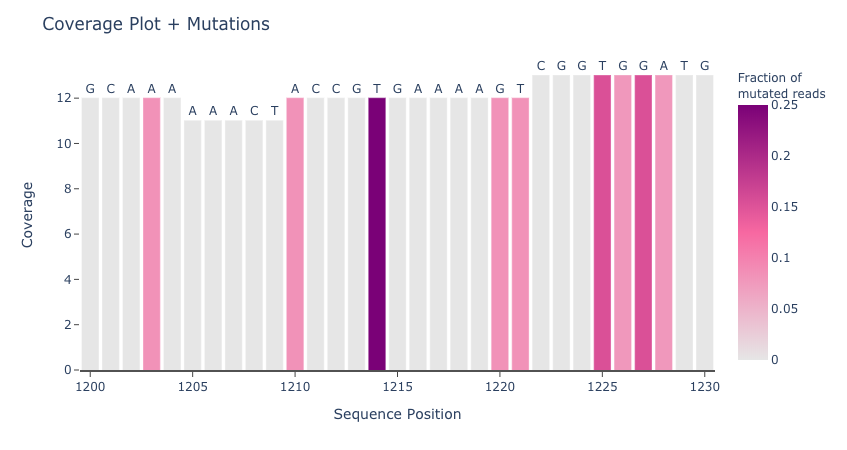

In [56]:
start_region = 1200
end_region = 1230

fig = plot_coverage_muts(start_pos_all, end_pos_all, start_region, end_region, muts_df_summary, ref_seq_list)

In [53]:
fig.write_html("small_region.html")

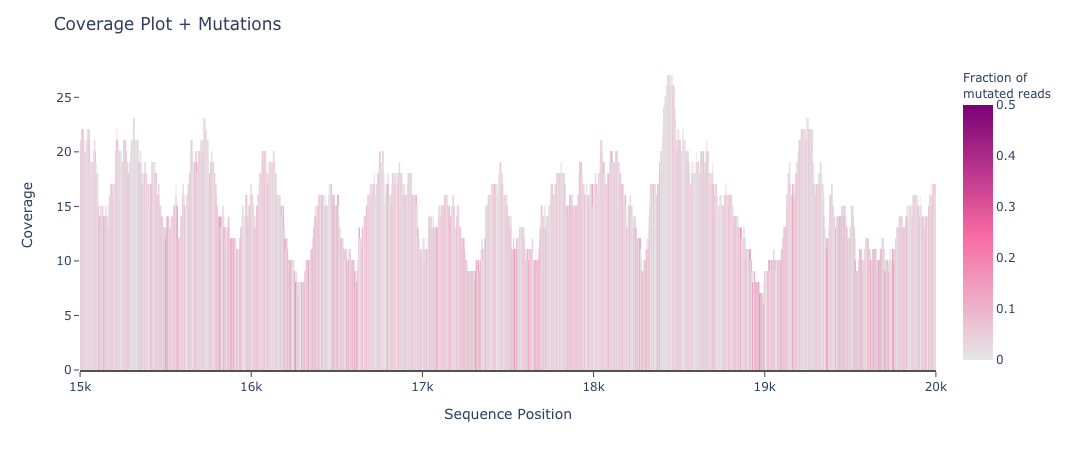

In [54]:
#larger region
start_region = 15000
end_region = 20000

fig = plot_coverage_muts(start_pos_all, end_pos_all, start_region, end_region, muts_df_summary, ref_seq_list)

In [55]:
fig.write_html("large_region.html")

## Final Thoughts

### Strengths:
 1. Calculation of coverage at each sequence position is efficient and scalable to large numbers of reads. The algorithm avoids doing a search through the reads for each position of interest, instead filtering for reads in the range of interest and calculating coverage at each position with a single pass through the chosen reads. This method will be much faster on large numbers of reads than methods that involve searching tables/lists.  
 
 2. Mutation information is presented in a clean and digestible manner - the use of color scales, hovertext, and labels allow for a single plot to store a lot of information without become cluttered. Someone interested in a low-resolution look at coverage/mutation can use the color scale on the plot find what regions have large numbers of reads with mutations. They can either rapidly replot the region of interest or use Plotly's zoom capabilities to zoom in. Hovertext can be used to examine the counts of the alternate bp at each position for more fine grained detail. At higher zoom, the reference sequence appears above the bars as additional information, though the hovertext also has the reference sequence information at lower zoom levels. 
 
 3. The plotting functions allow for flexible specification of the region of interest (can be as small or as large as desired) and only require sequence start and sequence end positions of the reads to be specified to view coverage. Since the coverage is calculated internally via an efficient algorithm, there is no need to store a list of sequence-wide (genome-wide here) coverages in memory prior to plotting. 
 
### Limitations:

1. Plotting time scales with size of the region of interest using matplotlib and plotly - to view extremely large sections of the genome e.g. 100KB - 1MB, plotting time will be quite slow. 

2. Unlike the IGV view, the breakdown of mutated vs. reference bp is not visible from the colors of the bar and has to be accessed using the hovertext, which is more cumbersome. In addition, the color scale highlights positions that have many mutations - if one is interested in any and all mutations at a position, they will have to rely on the hovertext to get that information. 

3. Currently the only way to plot a region is to manually specify the start and end positions. A more flexible view would be able to use available genome annotations to find regions based on chromosome, gene, exon, etc. 